<h1 align="center">МЧС: прогнозирование степени пожароопасности</h1>

![](https://habrastorage.org/webt/hw/ov/mm/hwovmmzc0n6y59iamjoa11zvce0.jpeg)

---

> **ЗАДАЧА:** разработать алгоритм, выдающий прогноз возникновения пожара (0 или 1) на 1, 2, 3, 4, 5, 6, 7 и 8 дней вперёд для заданной ячейки на определённую дату.  
> - ссылка задачи на [github Sber AI](https://github.com/sberbank-ai/no_fire_with_ai_aij2021)

---

<h1 align="center">Оглавление</h1>

- [1. Загрузка данных](#part1) <br>
    - [1.1 Климатические данные](#part1.1) <br>
    - [1.2 Таргеты](#part1.2) <br>
    - [1.3 OpenStreetMap](#part1.3) <br>
- [2. Генерация признаков](#part2) <br>
    - [2.1 Pooling features](#part2.1) <br>
    - [2.2 Categorical признаки даты](#part2.2) <br>
    - [2.3 Гео признаки](#part2.3) <br>
- [3. Обучение моделей](#part3) <br>
    - [3.1 Многоклассовая классификация](#part3.1) <br>
    - [3.2 Модель для каждого таргета](#part3.2) <br>
- [4. sample_submission.zip](#part4) <br>
- [5. Метрика соревнования](#part5) <br>

---

<h1 align="center">0. Импорт необходимых библиотек</h1>

> **NOTE**: Для некоторых библиотек потребуется установка дополнительных зависимостей. Более детальную информацию вы сможете найти в нашем **Dockerfile** и **requirements.txt**

In [1]:
import os
import pickle
import cfgrib
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# модули из репозитория https://github.com/sberbank-ai/no_fire_with_ai_aij2021
import helpers, preprocessing, features_generation, prepare_train
from solution import FEATURES

import warnings
warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (16,8)

---

<a id='part1'></a>
<h1 align="center">1. Загрузка данных</h1>

> **NOTE**: Для воспроизводимости бейзлайна, проверьте наличие файлов по пути **input/**:
```
├── city_town_village.geojson
├── ERA5_data
│   ├── evaporation1_2020.grib
│   ├── evaporation1_2021.grib
│   ├── evaporation2_2020.grib
│   ├── evaporation2_2021.grib
│   ├── heat1_2020.grib
│   ├── heat1_2021.grib
│   ├── heat2_2020.grib
│   ├── heat2_2021.grib
│   ├── temp_2018.grib
│   ├── temp_2020.grib
│   ├── temp_2021.grib
│   ├── vegetation_2020.grib
│   ├── vegetation_2021.grib
│   ├── wind_2020.grib
│   └── wind_2021.grib
├── train.csv
├── train_raw.csv
└── sample_test.csv
```

<a id='part1.1'></a>
<h2 align="center">1.1 Климатические данные</h2>

### Пример работы с файлом `.grib`

In [2]:
ds = cfgrib.open_datasets('input/ERA5_data/temp_2018.grib')

In [3]:
len(ds)

3

Файл представляет из себя несколько объектов формата `xarray.Dataset`, например, файл `temp_2018.grib` состоит из 3 объектов. Объекты содержат значения признаков для трех измерений **(latitude: 406, longitude: 1501, time: 365)**:
- Первый объект содержит следующий набор признаков:
    - stl1: Soil temperature level 1
- Второй объект содержит:
    - t2m: 2 metre temperature
    - d2m: 2 metre dewpoint temperature
- Третий объект содержит:
    - skt: Skin temperature

> **NOTE**: Данные признаки являются измерениями на определенную дату, в определенной широте и долготе, частота признаков 0.1 градус

In [4]:
ds[0].indexes['time'].min(), ds[0].indexes['time'].max()

(Timestamp('2018-01-01 14:00:00'), Timestamp('2018-12-31 14:00:00'))

In [5]:
# ds[2]

### Визуализация объекта `xarray.Dataset`

Очень хорошо видны очертания России 🇷🇺

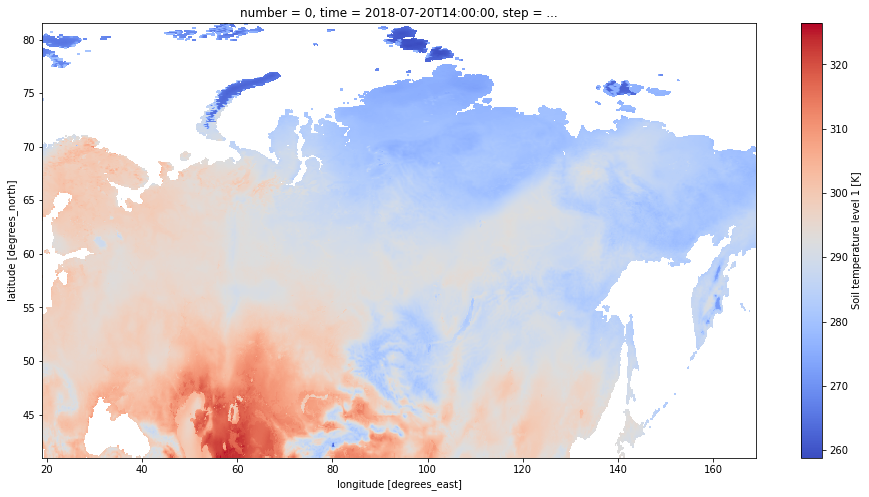

In [6]:
ds[0].stl1[200].plot(cmap=plt.cm.coolwarm);

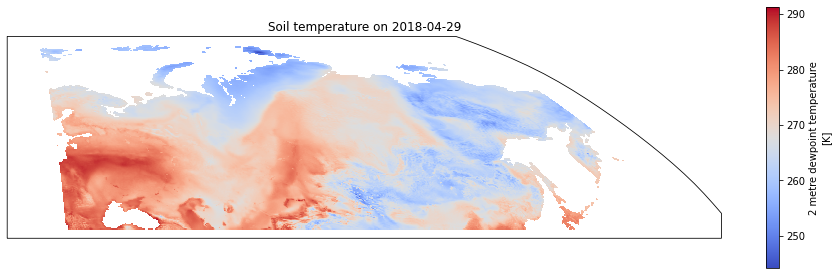

In [7]:
# Может понадобиться выполнение команд
# pip uninstall shapely
# pip install shapely --no-binary shapely

ax = plt.axes(projection=ccrs.Robinson())
# ax.coastlines(resolution='10m')
plot = ds[1].d2m[119].plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
plt.title('Soil temperature on 2018-04-29');

### Парсим куб из `xarray.Dataset` из файла `temp_2018.grib`

Для дальнейшей работы с климатическими признаками, можно парсить объекты `xarray.Dataset`, например, функциями `parse_dims` и `parse_cube`

> **NOTE**: 
> - Результат работы функции `parse_cube`: `словарь` ключ - название признака, значение - **3-мерный numpy массив** (день, ширина, долгота)
> - Результат работы функции `parse_dims`: **1-мерные массивы** с информацией о значениях осей 3-мерного массива.

In [8]:
times, latitudes, longitudes = preprocessing.parse_dims(ds)

Наблюдаем, что широта отсортирована по убыванию, что не естественно для матричного представления, учтем это

In [9]:
latitudes

Float64Index([              81.5,               81.4,  81.30000000000001,
               81.20000000000002,  81.10000000000002,  81.00000000000003,
               80.90000000000003,  80.80000000000004,  80.70000000000005,
               80.60000000000005,
              ...
               41.90000000000068,  41.80000000000068,  41.70000000000068,
              41.600000000000676, 41.500000000000675, 41.400000000000674,
               41.30000000000067,  41.20000000000067,  41.10000000000067,
               41.00000000000067],
             dtype='float64', name='latitude', length=406)

In [10]:
longitudes

Float64Index([              19.0,               19.1, 19.200000000000003,
              19.300000000000004, 19.400000000000006, 19.500000000000007,
               19.60000000000001,  19.70000000000001,  19.80000000000001,
              19.900000000000013,
              ...
              168.09999999999474, 168.19999999999473, 168.29999999999472,
              168.39999999999472,  168.4999999999947,  168.5999999999947,
               168.6999999999947,  168.7999999999947,  168.8999999999947,
              168.99999999999469],
             dtype='float64', name='longitude', length=1501)

<a id='part1.2'></a>
<h2 align="center">1.2 Таргеты</h2>

### Загружаем таргеты

####  `train_raw.csv`
Сырой датасет для обучения моделей.
- **dt** - Текущая дата наблюдения;
- **lon** - Координата конкретной точки пожара - `долготы`;
- **lat** - Координата конкретной точки пожара - `широты`;
- **type_id** - Код типа пожара;
- **type_name** - Наименование типа пожара;

In [11]:
train_raw = pd.read_csv('input/train_raw.csv', parse_dates=['dt'])
print(train_raw.shape)
train_raw.head()

(547763, 5)


,dt,lon,lat,type_id,type_name
0,2012-03-13,131.586613,47.866183,4,Природный пожар
1,2012-03-13,131.588507,47.880940,4,Природный пожар
2,2012-03-13,131.987129,48.497325,3,Лесной пожар
3,2012-03-13,131.903087,43.627665,4,Природный пожар
4,2012-03-13,131.570614,47.858103,4,Природный пожар


In [12]:
train_raw.dt.min(), train_raw.dt.max()

(Timestamp('2012-03-13 00:00:00'), Timestamp('2021-04-22 00:00:00'))

####  `train.csv`
Подготовленный датасет для обучения моделей. Получен с помощью функции `prepare_train.make_train` из сырого датасета для обучения.
- **dt** - Текущая дата наблюдения;
- **lon_min** - Нижняя граница ячейки наблюдения по `долготе`;
- **lat_min** - Нижняя граница ячейки наблюдения по `широте`;
- **lon_max** - Верхняя граница ячейки наблюдения по `долготе`;
- **lat_max** - Верхняя граница ячейки наблюдения по `широте`;
- **lon** - Координата конкретной точки пожара - `долготы` **(при наличии)**;
- **lat** - Координата конкретной точки пожара - `широты` **(при наличии)**;
- **grid_index** - Индекс ячейки **(подробности ниже)**;
- **type_id** - Код типа пожара **(при наличии)**;
- **type_name** - Наименование типа пожара **(при наличии)**;
- **is_land** - Метка того, был ли пожар на этой ячейке за всю историю (суша или нет);
--------------
- **infire_day_1** - `Целевая переменная` вероятность пожара на следующий день;
- **infire_day_2** - `Целевая переменная` вероятность пожара через 2 дня;
- **infire_day_3** - `Целевая переменная` вероятность пожара через 3 дня;
- **infire_day_4** - `Целевая переменная` вероятность пожара через 4 дня;
- **infire_day_5** - `Целевая переменная` вероятность пожара через 5 дней;
- **infire_day_6** - `Целевая переменная` вероятность пожара через 6 дней;
- **infire_day_7** - `Целевая переменная` вероятность пожара через 7 дней;
- **infire_day_8** - `Целевая переменная` вероятность пожара через 8 дней;

> **NOTE**:
> - Размер ячейки 0.2 x 0.2 широты - долготы
> - В рамках этого бейзлайна, выбираем данные для обучения **только** с 2020 года

Для удобства добавления признаков к нашим наблюдениям можно использовать `grid_index`, который заменит границы ячейки одним числом, которое вычисляется по простой формуле:

$$\mathcal grid\_index = row_i * col_n + col_i,$$  
в нашем случае всего столбцов (`col_n`) - **750**, всего строк - **203**.

> **NOTE**: В качестве начальных значений для индексации будем использовать **минимальные** значения ширины и долготы в файлах `.grib`, по той причине - потому что они меньше, чем минимальные значения в таргетах

![](https://habrastorage.org/webt/ji/cf/js/jicfjs3yfotvsvwxsp85eqifxtq.jpeg)

In [13]:
lat_min = round(latitudes.min(), 1)
lat_max = round(latitudes.max(), 1)

lon_min = round(longitudes.min(), 1)
lon_max = round(longitudes.max(), 1)

lat_min, lat_max, lon_min, lon_max

(41.0, 81.5, 19.0, 169.0)

In [14]:
step = 0.2
array_of_lats = np.arange(lat_min, lat_max, step).round(1)
array_of_lons = np.arange(lon_min, lon_max, step).round(1)
print(len(array_of_lats), len(array_of_lons))

203 750


In [15]:
# train = prepare_train.make_train('input/train_raw.csv',
#                                  array_of_lons, array_of_lats, step,
#                                  start_date='2020-01-01')
train = pd.read_csv('input/train.csv', parse_dates=['dt'])
print(train.shape)
train.head()

(488103, 19)


,dt,lon_min,lat_min,lon_max,lat_max,lon,lat,grid_index,type_id,type_name,is_land,infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,2020-05-04,47.6,41.0,47.8,41.2,NaN,NaN,143,NaN,NaN,False,0,0,0,0,0,0,0,0
1,2021-02-24,47.2,41.2,47.4,41.4,NaN,NaN,891,NaN,NaN,False,0,0,0,0,0,0,0,0
2,2021-02-27,47.2,41.2,47.4,41.4,NaN,NaN,891,NaN,NaN,False,0,0,0,0,0,0,0,0
3,2021-04-01,47.4,41.2,47.6,41.4,NaN,NaN,892,NaN,NaN,True,0,0,0,0,0,0,0,0
4,2020-03-14,47.6,41.2,47.8,41.4,NaN,NaN,893,NaN,NaN,True,0,0,0,0,0,0,0,0


In [16]:
train.dt.min(), train.dt.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-04-22 00:00:00'))

####  `sample_test.csv`
Пример датасета для создания паблик-лидерборда.
- **id** - Id строки для оценки предсказаний;
- **dt** - Текущая дата наблюдения;
- **lon_min** - Нижняя граница ячейки наблюдения по `долготе`;
- **lat_min** - Нижняя граница ячейки наблюдения по `широте`;
- **lon_max** - Верхняя граница ячейки наблюдения по `долготе`;
- **lat_max** - Верхняя граница ячейки наблюдения по `широте`;
- **lon** - Координата конкретной точки пожара - `долготы` **(при наличии)**;
- **lat** - Координата конкретной точки пожара - `широты` **(при наличии)**;
- **grid_index** - Индекс ячейки;
- **type_id** - Код типа пожара **(при наличии)**;
- **type_name** - Наименование типа пожара **(при наличии)**;

In [17]:
sample_test = pd.read_csv('input/sample_test.csv', parse_dates=['dt'])
print(sample_test.shape)
sample_test.head()

(5, 11)


,id,dt,lon_min,lat_min,lon_max,lat_max,lon,lat,grid_index,type_id,type_name
0,0,2021-05-26,47.6,41.0,47.8,41.2,NaN,NaN,143,NaN,NaN
1,1,2021-06-13,47.6,41.0,47.8,41.2,NaN,NaN,143,NaN,NaN
2,2,2021-06-30,47.6,41.0,47.8,41.2,NaN,NaN,143,NaN,NaN
3,3,2021-05-22,47.8,41.2,48.0,41.4,NaN,NaN,894,NaN,NaN
4,4,2021-05-11,47.2,41.6,47.4,41.8,NaN,NaN,2391,NaN,NaN


### Разделим выборку `train` на `train/val` датасеты

In [18]:
val = train[train.dt >= "2021-02-01"].reset_index(drop=True)
train = train[train.dt < "2021-02-01"].reset_index(drop=True)
train.shape, val.shape

((414455, 19), (73648, 19))

### Посмотрим на распределение таргетов:

In [19]:
train[['infire_day_1', 'infire_day_2', 'infire_day_3',
       'infire_day_4', 'infire_day_5', 'infire_day_6',
       'infire_day_7', 'infire_day_8']].apply(pd.Series.value_counts)

,infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,362251,362248,362244,362240,362233,362223,362223,362219
1,52204,52207,52211,52215,52222,52232,52232,52236


In [20]:
val[['infire_day_1', 'infire_day_2', 'infire_day_3',
       'infire_day_4', 'infire_day_5', 'infire_day_6',
       'infire_day_7', 'infire_day_8']].apply(pd.Series.value_counts)

,infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,68472,68014,67461,67032,66529,65892,65406,64782
1,5176,5634,6187,6616,7119,7756,8242,8866


<a id='part1.3'></a>
<h2 align="center">1.3 OpenStreetMap</h2>

### Скачиваем информацию используя `OSMPythonTools` по ключу [Key:place](https://wiki.openstreetmap.org/wiki/Key:place)

- Обратите внимание на [Key:natural](https://wiki.openstreetmap.org/wiki/Key:natural)
- если загрузка слишком долгая, можно воспользоваться веб-сервисом `https://overpass-turbo.eu/#`, выполнить запрос, экспортировать в файл, например `.geojson`. (При обращении к api есть квота по ip)

Пример запроса к веб-сервису, который идентичен коду ниже:

```
[out:json][timeout:1000];
area(3600060189)->.searchArea;
(
  node["place"~"city|town|village"](area.searchArea);
  way["place"~"city|town|village"](area.searchArea);
  relation["place"~"city|town|village"](area.searchArea);
);
out body;
>;

```  

>**NOTE**: файл **city_town_village.geojson** получен именно таким образом

In [21]:
# nominatim = Nominatim()
# areaId = nominatim.query('Россия').areaId()
# areaId

In [22]:
# overpass = Overpass()
# query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector='"place"~"city|town|village"')
# result = overpass.query(query, timeout=1000)
# res_json = result.toJSON()

### Загружаем `.geojson` в `geopandas`

Итак, мы получили файл `*.geojson` одним из двух способов, далее будем работать с ним с помощью библиотеки `geopandas`.
> **NOTE**: Для примера, выбраны не все потенциально полезные столбцы;  
Также можно учесть, что значение признака `population` было зафиксировано на определенную дату. В данном бейзлайне пренебрегаем возможным `data leakage` и не актуальным значением.

In [23]:
cities_df = gpd.read_file('input/city_town_village.geojson')
cities_df = cities_df[['admin_level', 'name', 'population', 'population:date', 'place', 'geometry']]
cities_df = cities_df[cities_df.place != 'city_block'].reset_index(drop=True)
cities_df['lon'] = cities_df['geometry'].x
cities_df['lat'] = cities_df['geometry'].y

cities_df.loc[cities_df.lon < 0, 'lon'] += 360
cities_df.loc[cities_df.population.notna(), 'population'] = cities_df[cities_df.population.notna()]\
                            .population.apply(helpers.split_string).str.replace(" ", "").astype(int)
cities_df.head()

,admin_level,name,population,population:date,place,geometry,lon,lat
0,3,Новосибирск,1625600,2020-01-01,city,POINT (82.92345 55.02822),82.923451,55.028217
1,None,Невель,16272,None,town,POINT (29.91713 56.01762),29.917128,56.017616
2,None,Кандалакша,30575,2019-01-01,town,POINT (32.41306 67.15144),32.413055,67.151442
3,6,Апатиты,55713,2018-01-01,town,POINT (33.40439 67.56863),33.404392,67.568626
4,None,Калевала,3855,2019-01-01,town,POINT (31.18017 65.20010),31.180172,65.200096


### Переводим значения city_lon и city_lat к нашей сетке

Координаты центра каждого поселения переводим в рамки наших границ ячеек, как в таргетах

In [24]:
cities_df = helpers.add_edges_polygon(cities_df)
cities_df = cities_df[(cities_df.lon_max <= lon_max) &\
                      (cities_df.lon_min >= lon_min) &\
                      (cities_df.lat_min >= lat_min) &\
                      (cities_df.lat_max <= lat_max)].reset_index(drop=True)

### Добавляем `grid_index` для городов

После того как мы добавили границы для ячейки размера 0.2 x 0.2 широты - долготы, можем добавить `grid_index`

In [25]:
cities_df = helpers.get_grid_index(cities_df, array_of_lons, array_of_lats)

### Переименовываем для удобства

In [26]:
cities_df.rename(columns={'lon': 'city_lon',
                          'lat': 'city_lat'}, inplace=True)
cities_df.head()

,admin_level,name,population,population:date,place,geometry,city_lon,city_lat,lon_min,lon_max,lat_min,lat_max,grid_index
0,3,Новосибирск,1625600,2020-01-01,city,POINT (82.92345 55.02822),82.923451,55.028217,82.8,83.0,55.0,55.2,52819
1,None,Невель,16272,None,town,POINT (29.91713 56.01762),29.917128,56.017616,29.8,30.0,56.0,56.2,56304
2,None,Кандалакша,30575,2019-01-01,town,POINT (32.41306 67.15144),32.413055,67.151442,32.4,32.6,67.0,67.2,97567
3,6,Апатиты,55713,2018-01-01,town,POINT (33.40439 67.56863),33.404392,67.568626,33.4,33.6,67.4,67.6,99072
4,None,Калевала,3855,2019-01-01,town,POINT (31.18017 65.20010),31.180172,65.200096,31.0,31.2,65.2,65.4,90810


---

<a id='part2'></a>
<h1 align="center">2. Генерация признаков</h1>

<a id='part2.1'></a>
<h2 align="center">2.1 Pooling features</h2>

![](https://habrastorage.org/webt/dy/w1/_k/dyw1_kokc_kch6f-d37esfptjbw.jpeg)

Так как в нашем датасете у таргетов размер ячеек 0.2 x 0.2, а у климатических признаков частота измерений 0.1, мы можем использовать либо всю матрицу 0.2 х 0.2 целиком, либо использовать `pooling` c `kernel_size` = 3 и `stride` = 2

### Считаем `pooling features`
И сразу переводим в так называемый `grid_index`, по которому в дальнейшем будем матчить с таргетами и сохраняем полученные тензоры в `additional_data/`

> **NOTE**: 
> - Так как для обучения мы взяли данные **только** с 2020 года, соответственно считаем `poolling features` также только для данных с 2020 года;  
> - Выберем все доступные признаки из климатических

In [27]:
%%time

PATH_TO_ADD_DATA = 'additional_data/'

grib_list = [el.split('.')[0] for el in os.listdir("input/ERA5_data")\
             if el.startswith(("temp", "wind",
                               "evaporation1", "evaporation2",
                               "heat1", "heat2", "vegetation")) and el.endswith(('2020.grib', '2021.grib'))]

for file_name in grib_list:
    preprocessing.make_pool_features("input/ERA5_data",
                                     file_name, PATH_TO_ADD_DATA)

CPU times: user 6min 8s, sys: 1min 8s, total: 7min 16s
Wall time: 9min 18s


### Добавляем признаки из подготовленного тензорного представления

In [28]:
%%time
PATH_TO_ADD_DATA = 'additional_data/'
train = features_generation.add_pooling_features(train, PATH_TO_ADD_DATA, count_lag=3)
val = features_generation.add_pooling_features(val, PATH_TO_ADD_DATA, count_lag=3)

CPU times: user 10min 55s, sys: 59.4 s, total: 11min 55s
Wall time: 12min 16s


<a id='part2.2'></a>
<h2 align="center">2.2 Categorical признаки даты</h2>

Добавляем в качестве категориальных признаков - месяц, день месяца, неделя с начала года, день недели.

In [29]:
train = features_generation.add_cat_date_features(train)
val = features_generation.add_cat_date_features(val)

<a id='part2.3'></a>
<h2 align="center">2.3 Гео признаки</h2>

****Добавляем признаки полученные из `OpenStreetMap`****:
- **distance_to_nearest_city** - расстояние до ближайшего населенного пункта;
- **place** - тип населенного пункта;
- **population** - численность населения

In [30]:
%%time
train = features_generation.add_geo_features(train, cities_df)
val = features_generation.add_geo_features(val, cities_df)

CPU times: user 22.5 s, sys: 436 ms, total: 22.9 s
Wall time: 23 s


---

<a id='part3'></a>
<h1 align="center">3. Обучение моделей</h1>

Итак, наш датасет готов, можем приступать к обучению.  
В качестве бейзлайна выбрана модель `CatBoostClassifier`.
> **NOTE**: 
> - для каждого из таргетов будем обучать классификатор отдельно
> - мы не прогнозируем как быстро пожар будут тушить, это зависит от многих факторов и не является приоритетным для данной задачи, поэтому изменим таргеты, так же, как и при расчете метрики, подробности в `README.MD`
> - добавим девятую модель - многоклассовую классификацию для предсказания начала пожара, с помощью этой модели будем модифицировать наши предсказания/или же только ее использовать для предсказаний

In [31]:
cat_features = ['month', 'day', 'weekofyear', 'dayofweek', 'place']
cat_features = train[FEATURES].columns.intersection(cat_features)
cat_features = [train[FEATURES].columns.get_loc(feat) for feat in cat_features]
cat_features

[201, 203, 204, 205, 206]

<a id='part3.1'></a>
<h2 align="center">3.1 Многоклассовая классификация</h2>

#### Создадим таргет - через какое количество дней начнется пожар

In [32]:
def get_multiclass_target(df):
    df = df.copy()
    for i in range(8, 0, -1):
        df.loc[df[f'infire_day_{i}'] == 1, 'multiclass'] = i
    df.fillna(0, inplace=True)
    return df.multiclass

In [33]:
train_targets = train.iloc[:,11:11+8]
val_targets = val.iloc[:,11:11+8]

train_target_mc = get_multiclass_target(train_targets)
val_target_mc = get_multiclass_target(val_targets)

In [34]:
train_dataset_mc = Pool(data=train[FEATURES],
                    label=train_target_mc,
                    cat_features=cat_features)

eval_dataset_mc = Pool(data=val[FEATURES],
                    label=val_target_mc,
                    cat_features=cat_features)
model_mc = CatBoostClassifier(iterations=100, random_seed=8,
                              eval_metric='MultiClass', auto_class_weights="Balanced")
model_mc.fit(train_dataset_mc,
          eval_set=eval_dataset_mc,
          verbose=False)

<a id='part3.2'></a>
<h2 align="center">3.2 Модель для каждого таргета</h2>

#### Изменим таргеты в соответствии с метрикой

In [35]:
train_targets = (
    train_targets.replace(0, np.nan).fillna(axis=1, method="ffill").fillna(0).astype(int)
)

val_targets = (
    val_targets.replace(0, np.nan).fillna(axis=1, method="ffill").fillna(0).astype(int)
)

In [36]:
models = []
for i in range(8):
    train_dataset = Pool(data=train[FEATURES],
                        label=train_targets.iloc[:,i],
                        cat_features=cat_features)

    eval_dataset = Pool(data=val[FEATURES],
                        label=val_targets.iloc[:,i],
                        cat_features=cat_features)
    model = CatBoostClassifier(iterations=100, random_seed=i+1, eval_metric='F1', auto_class_weights="Balanced")
    model.fit(train_dataset,
              eval_set=eval_dataset,
              verbose=False)
    models.append(model)

### Сохраняем модели в `models/`

In [37]:
if not os.path.exists("models/"):
    os.mkdir("models/")
for idx, model in enumerate(models):
    path_to_model = f"models/model_{idx+1}_day.pkl"

    with open(path_to_model, 'wb') as f:  
        pickle.dump(model, f)
        
with open("models/model_mc.pkl", 'wb') as f:  
    pickle.dump(model_mc, f)

---

<a id='part4'></a>
<h1 align="center">4. sample_submission.zip</h1>

В качестве решения от участников требуется архив `*.zip`:

```
.
├── features_generation.py
├── helpers.py
├── metadata.json
├── models
│   ├── model_1_day.pkl
│   ├── model_2_day.pkl
│   ├── model_3_day.pkl
│   ├── model_4_day.pkl
│   ├── model_5_day.pkl
│   ├── model_6_day.pkl
│   ├── model_7_day.pkl
│   ├── model_8_day.pkl
│   └── model_mc.pkl
│
├── prepare_train.py
├── preprocessing.py
└── solution.py

```

- В директории `models/` обязательно должны быть файлы с моделями.
- В директории `additional_data/` могут быть дополнительные данные для обучения модели; Директории может не быть.
- Помимо обязательного модуля `solution.py` могут быть вспомогательные модули.
- Файл `metadata.json` содержит название `docker image` и команду для расчета предсказаний -  `output.csv` таблицы, которая связана с датасетом `test.csv` с помощью поля `id`:
```
id, infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
```

In [38]:
!zip -r sample_submission.zip *.py models/ metadata.json >/dev/null

---

<a id='part5'></a>
<h1 align="center">5. Метрика соревнования</h1>

> **NOTE**: 
> - Код метрики представлен в `helpers.competition_metric`
> - Лучшее значение метрики → 1, худшее → 0

#### В качестве примера расчета метрики, рассмотрим 2 датасета

In [39]:
pred = pd.DataFrame({'infire_day_1': [1, 0, 1, 0, 0],
                     'infire_day_2': [1, 0, 1, 0, 0],
                     'infire_day_3': [1, 0, 1, 0, 0],
                     'infire_day_4': [1, 0, 0, 0, 0],
                     'infire_day_5': [1, 1, 0, 0, 1],
                     'infire_day_6': [1, 0, 1, 0, 1],
                     'infire_day_7': [1, 0, 1, 0, 0],
                     'infire_day_8': [1, 0, 1, 0, 1],
                    })

pred

,infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,1,1,1,1,1,1,1,1
1,0,0,0,0,1,0,0,0
2,1,1,1,0,0,1,1,1
3,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,1


In [40]:
gt = pd.DataFrame({'infire_day_1': [0, 0, 0, 0, 0],
                   'infire_day_2': [0, 0, 0, 0, 0],
                   'infire_day_3': [1, 0, 0, 0, 1],
                   'infire_day_4': [0, 1, 0, 0, 1],
                   'infire_day_5': [0, 0, 0, 0, 1],
                   'infire_day_6': [0, 0, 0, 0, 0],
                   'infire_day_7': [1, 0, 0, 0, 0],
                   'infire_day_8': [0, 0, 0, 0, 0],
                  })

gt

,infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0


In [41]:
helpers.competition_metric(gt, pred)

0.89114